# Downstream analysis - Simulate Gene Intervention (Knock out) 

In [1]:
import pandas as pd
import shutil
import tempfile
import os
from tqdm import tqdm

from functions.analysis_utils.stats.stats_proba import compute_mannwhitneyu_test_means

from functions.analysis_utils.genes_intervention.pers_interventions import tailor_bnd_genes_intervention


from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table


from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import collect_group_data

from functions.analysis import downstream_analysis


from functions.generate_models import generate_models_re, pre_process_re



In [2]:
genes_diff_expressed_data = pd.read_csv('analysis/Refametinib/genes_models/MEK1_MEK2_target_block/results/genes_diff_expressed/significant_genes_EGF_ON_INVASION.csv')

In [3]:
# genes_diff_expressed_data['diff_mean'] = genes_diff_expressed_data['Group Resistant Mean'] - genes_diff_expressed_data['Group Sensitive Mean']
# genes_diff_expressed_data.head()

# # CCND1 more expressed in sensitive but high variability as well 
# # FOXA1 the more expressed in the resistant 
# # E2F1 smallest p value 

# genes_diff_expressed_data.sort_values(by='diff_mean', ascending=True)
# # genes_diff_expressed_data.sort_values(by='P-value')


### Users data parameters

In [4]:
drug_interest = 'Refametinib'
drug_targets = ['MEK1', 'MEK2']
type_models = 'genes_models'  # 'genes_models' or 'proteins_models'



input_interest = 'EGF'
phenotype_interest = 'INVASION'



gene_diff_expr = f'significant_genes_{input_interest}_ON_{phenotype_interest}'



inputs_list = ['EGF', 'FGF', 'TGFB', 'ANDROGEN', 'HYPOXIA', 'NUTRIENTS', 'CARCINOGEN', 'ACIDOSIS', 'TNF', 'SPOP']
phenotypes_list = ['PROLIFERATION', 'DNA_REPAIR', 'INVASION', 'APOPTOSIS', 'MIGRATION']


In [5]:
# genes_to_test = ['FOXA1', 'BIRC5', 'BCL2', 'MDM2', 'E2F1']


genes_to_test = ['BCL2'] # gene that encode Beta catenin
number_patients = 35

genetic_intervention = 'KO'

In [6]:
# subdir = f"{'_'.join(drug_targets)}_target_block"
subdir = f"{'_'.join(genes_to_test + [genetic_intervention])}_target_block"


folder_results = f"analysis/{drug_interest}/downstream_analysis/{subdir}/{type_models}"

folder_generic_models = f"analysis/{drug_interest}/downstream_analysis/{subdir}/{type_models}/models/generic"

folder_models = f"analysis/{drug_interest}/downstream_analysis/{subdir}/{type_models}/models_intervention"





In [7]:
# Loading the data (TCGA, cell model passport)

annotations_models = pd.read_csv('data/model_list_20250407.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')

montagud_data = (
    pd.read_csv('data/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])
rna_seq_data = pd.read_csv('data/rnaseq_merged/rnaseq_merged_20250117.csv')
cnv_data = pd.read_csv('data/cellmodel_data/cnv_summary_20250207.csv')

proteins_data = pd.read_csv('data/cellmodel_data/proteomics_all_20250211.csv')


models_depmap_annotation = pd.read_csv('data/cellmodel_data/model_list_20250423.csv')
mutations_data_depseq = pd.read_csv('data/depmap_data/OmicsSomaticMutations.csv')


/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_74359/1608168518.py:16: DtypeWarning: Columns (22,50,56,57,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations_data_depseq = pd.read_csv('data/depmap_data/OmicsSomaticMutations.csv')


In [8]:
# models inputs
patients_categ = ['resistant', 'sensitive', 'healthy']

inputs_list = ['EGF', 'FGF', 'TGFB', 'ANDROGEN', 'HYPOXIA', 'NUTRIENTS', 'CARCINOGEN', 'ACIDOSIS', 'TNF', 'SPOP']

# models outputs
phenotype_interest = ["PROLIFERATION","INVASION","DNA_REPAIR","APOPTOSIS"]



annotations_models = pd.read_csv('data/model_list_20250407.csv')
# Montagud analysis - Growth factors (EGF and FGF), Nutrients and Androgen ON
# Montagud analysis - Carcinogen, Androgen, TNFalpha, Acidosis, and Hypoxia
list_active_inputs =  [['EGF', 'FGF', 'NUTRIENTS', 'ANDROGEN'], 
                        ['CARCINOGEN', 'ANDROGEN', 'TNF', 'ACIDOSIS', 'HYPOXIA']
                        ]


name_montagud_maps = {
        "CASPASE8": "CASP8",
        "CASPASE3": "CASP3",
        "CASPASE9": "CASP9",
        "CYCLINB": "CCNB1",
        "CYCLIND": "CCND1",
        "DSH": "DVL1",
        "BETA_CATENIN": "CTNNB1",
        "E_CADHERIN": "CDH1",
        "CYCC": "CYCS",
        "MEK1_2": "MEK1",
        "NF_KB": "NFKB",
        "SNAIL": "SNAI1",
        "TNFALPHA": "TNF",
        "TSC1_2": "TSC1",
        "BCL_XL": "BCL2L1",
        "MAP3K1_3": "MAP3K1",
        "CHK1_2": "CHK1",
    }

nodes_add = ['MEK2', 'TSC2', 'MAP3K3', 'CHK2']
nodes_to_add = {'MEK1':'MEK2', 'TSC1':'TSC2', 'MAP3K1':'MAP3K3', 'CHK1':'CHK2'}



# proteins synonyms 
synonyms_maps = {
        "RAF1": "RAF",
        "BCL2L2": "BCL2",
        "SMAD1": "SMAD",
        "SMAD3": "SMAD",
        "SMAD4": "SMAD",
        "SMAD5": "SMAD",
        "BAK1": "BAK",
        "GSK3A": "GSK3",
        "GSK3B": "GSK3",
        "TGFBR2": "TGFBR",
        "TGFBR3": "TGFBR",
        "NRAS": "RAS",
        "KRAS": "RAS",
        "HRAS": "RAS",
        "AKT2": "AKT",
        "MYCN": "MYC",
        }

tissue_interest = 'PAN_CANCER'
tissue_remove = 'Haematopoietic and Lymphoid'



# Models parameters
nodes_to_remove = ['FUSED_EVENT', 'AR_ERG']


In [9]:

top_resistant_ids, top_sensitive_ids, top_healthy_ids, montagud_nodes, rna_seq_data_filtered, cnv_data_filtered, table_rna_seq_patients, df_melted_protein, table_proteins_patients = pre_process_re(
    montagud_data,
    rna_seq_data,
    cnv_data,
    number_patients,
    drug_data,
    annotations_models,
    drug_interest,
    proteins_data,
    type_models,
    name_montagud_maps,
    nodes_add,
    synonyms_maps,
    tissue_interest=None,
    tissue_remove=None,
    nodes_to_remove=nodes_to_remove,
)

/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/identification_patients/get_patients_sens_res.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_models_filtered.rename(
/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/pre_process_data/pre_process_genes.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data.rename(columns={"gene_symbol": "gene_name"}, inplace=True)
/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/pre_process_data/pre_process_proteins.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

preprocessed  proteins


Gene intervention = gene of interest 

In [10]:

dest_dir = f"analysis/{drug_interest}/downstream_analysis/{subdir}/{type_models}/models/generic/"
os.makedirs(dest_dir, exist_ok=True)

# Copy the files
shutil.copy('analysis/generic_models/Montagud2022_Prostate_Cancer.bnd', dest_dir)
shutil.copy('analysis/generic_models/Montagud2022_Prostate_Cancer.cfg', dest_dir) 

'analysis/Refametinib/downstream_analysis/BCL2_KO_target_block/genes_models/models/generic/Montagud2022_Prostate_Cancer.cfg'

In [11]:
# simulate a knockin of the gene 
generate_models_re(
    folder_generic_models,
    folder_models,
    top_resistant_ids,
    top_sensitive_ids,
    top_healthy_ids,
    drug_interest,
    drug_targets,
    phenotype_interest,
    rna_seq_data,
    montagud_nodes,
    table_rna_seq_patients,
    cnv_data_filtered,
    name_montagud_maps,
    type_models,
    df_melted_protein,
    table_proteins_patients,
    nodes_to_remove = nodes_to_remove,
    nodes_to_add = nodes_to_add,
    intervention_gene = genes_to_test,
    genetic_intervention= genetic_intervention

)

change manually the bnd files with the node to remove
change manually the bnd files with the node to remove
All .cfg and .bnd files created for sensitive, resistant and healthy patients.
🔍 Processing patient SIDM00415, gene: MEK1
MEK1 node found. Replacing...
SIDM00415: CNV — nodes modified
🔍 Processing patient SIDM00415, gene: MEK2
MEK2 node found. Replacing...
SIDM00415: CNV — nodes modified
🔍 Processing patient SIDM00255, gene: MEK1
MEK1 node found. Replacing...
SIDM00255: CNV — nodes modified
🔍 Processing patient SIDM00255, gene: MEK2
MEK2 node found. Replacing...
SIDM00255: CNV — nodes modified
🔍 Processing patient SIDM00770, gene: MEK1
MEK1 node found. Replacing...
SIDM00770: CNV — nodes modified
🔍 Processing patient SIDM00770, gene: MEK2
MEK2 node found. Replacing...
SIDM00770: CNV — nodes modified
🔍 Processing patient SIDM00416, gene: MEK1
MEK1 node found. Replacing...
SIDM00416: CNV — nodes modified
🔍 Processing patient SIDM00416, gene: MEK2
MEK2 node found. Replacing...
SIDM0

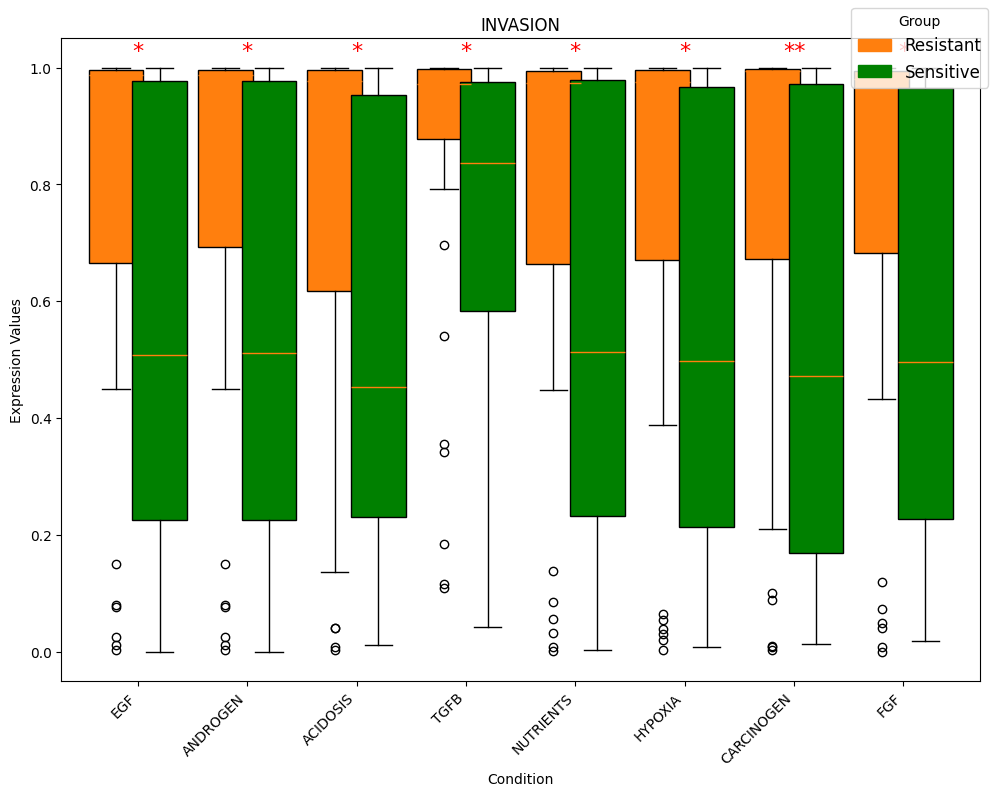

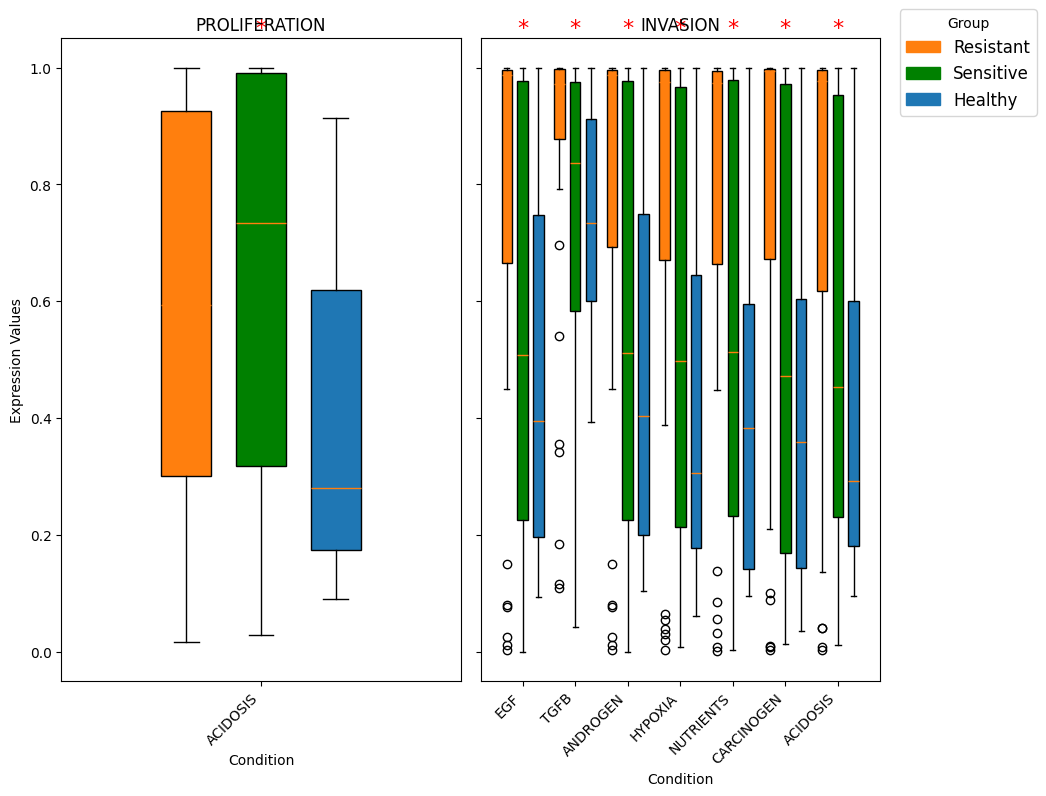

/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/MaBoSS_simulation/maboss_phenotype_patient.py:262: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  patient_mean.loc[condition][phenotype] = mean
/Users/romane/repos/icr/Attr

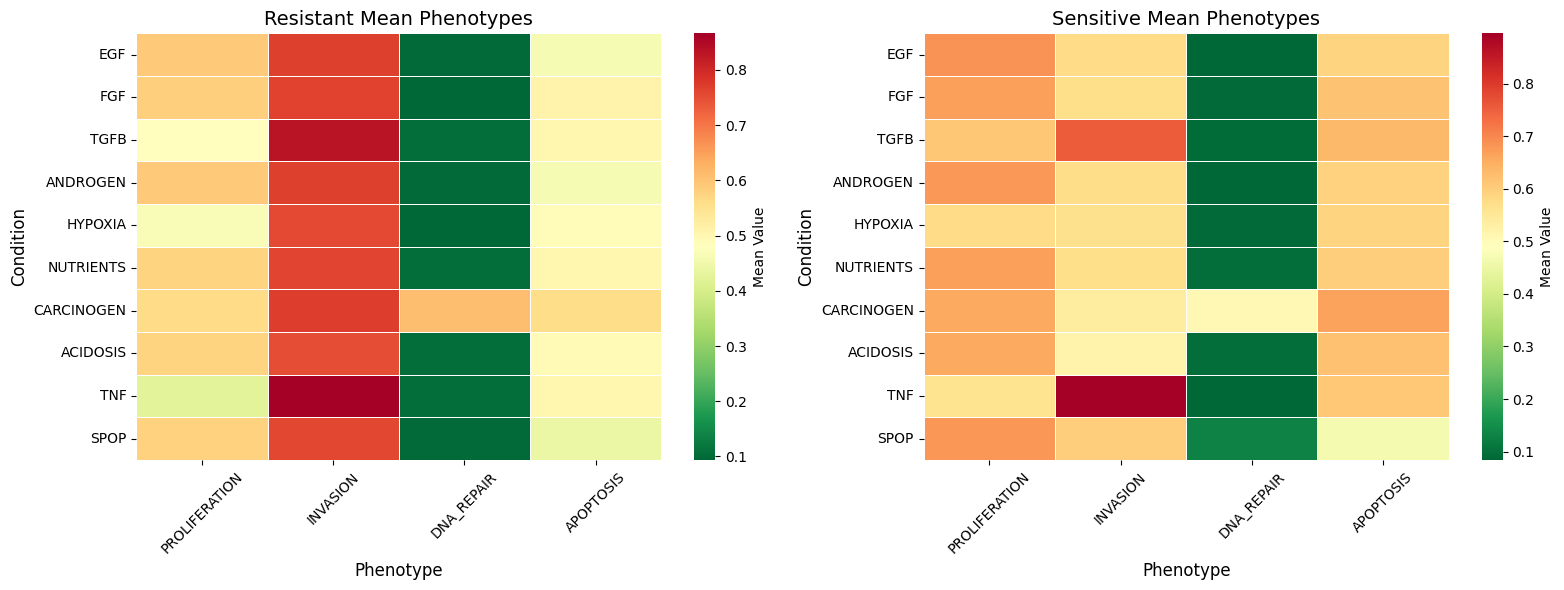

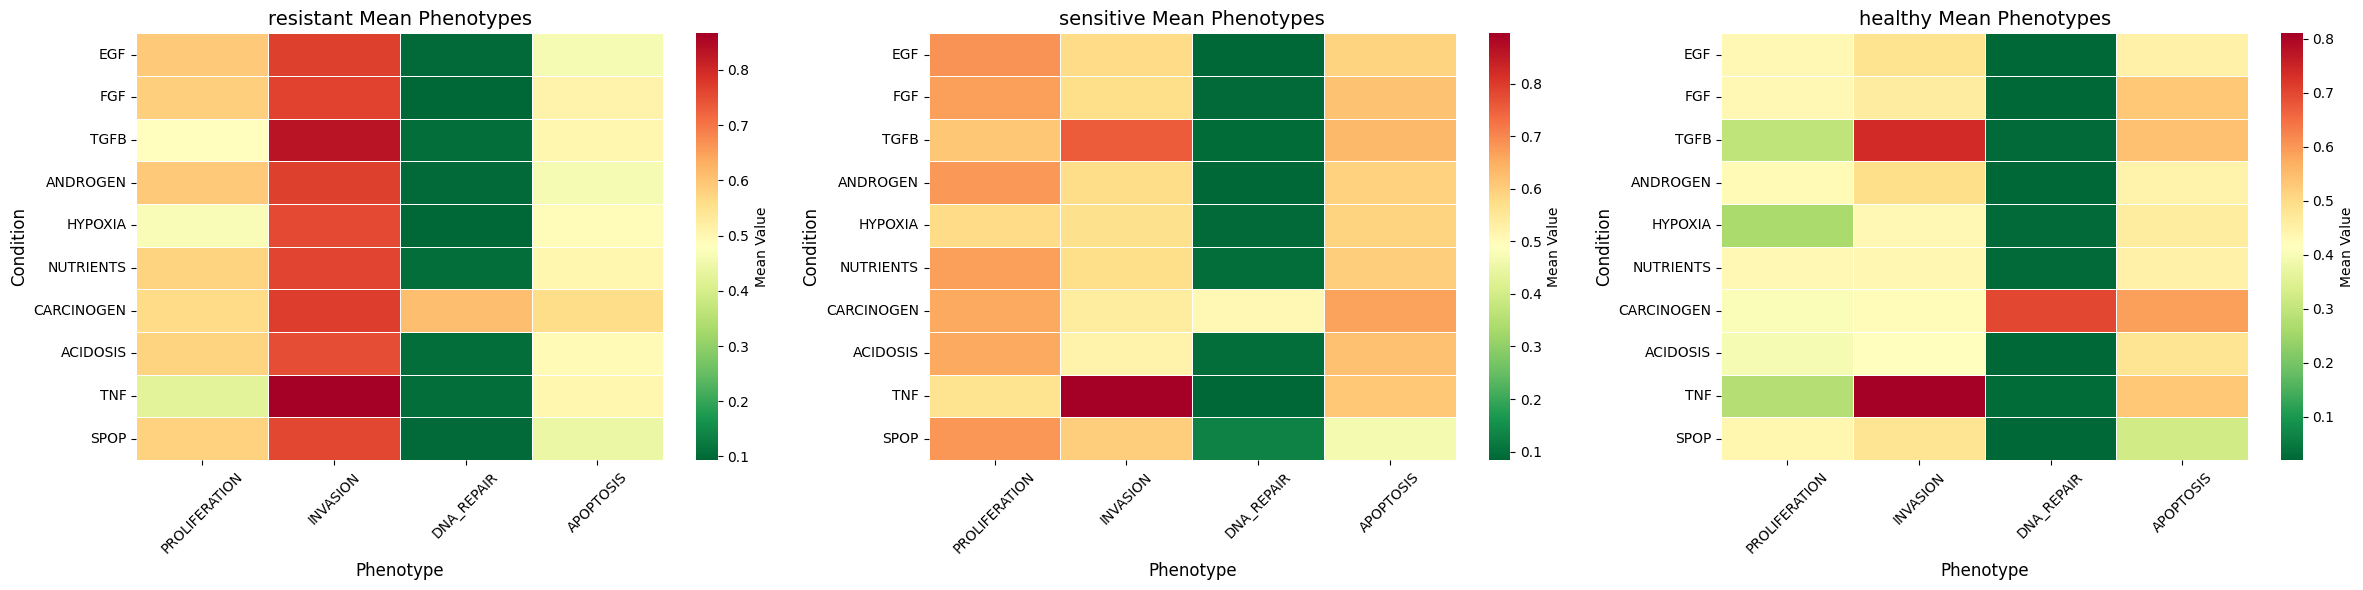

['SIDM01056', 'SIDM00770', 'SIDM00767', 'SIDM01120', 'SIDM00415', 'SIDM00562', 'SIDM00416', 'SIDM00920', 'SIDM00506', 'SIDM00710', 'SIDM00881', 'SIDM00700', 'SIDM00892', 'SIDM00886', 'SIDM00266', 'SIDM00716', 'SIDM00444', 'SIDM00524', 'SIDM01177', 'SIDM00255', 'SIDM00719', 'SIDM00283', 'SIDM00683', 'SIDM00697', 'SIDM00286', 'SIDM00292', 'SIDM00870', 'SIDM00521', 'SIDM00508', 'SIDM00631', 'SIDM00424', 'SIDM00971', 'SIDM00391', 'SIDM01259', 'SIDM01240', 'SIDM01242', 'SIDM00428', 'SIDM00987', 'SIDM00944', 'SIDM00826', 'SIDM00588', 'SIDM01141', 'SIDM00462', 'SIDM00890', 'SIDM01019', 'SIDM00850', 'SIDM00108', 'SIDM00337', 'SIDM01001', 'SIDM01015', 'SIDM00527', 'SIDM00056', 'SIDM00081', 'SIDM00446', 'SIDM00136', 'SIDM00496', 'SIDM00284', 'SIDM00910', 'SIDM00695', 'SIDM00619', 'SIDM00974', 'SIDM01101', 'SIDM00380', 'SIDM01059', 'SIDM00795', 'SIDM00568', 'SIDM01072', 'SIDM01066', 'SIDM00580']
Saved final phenotype table to: analysis/Refametinib/downstream_analysis/BCL2_KO_target_block/genes_mo

/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/romane/repos/icr/Attractor-Resistance/.env/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*sampl

In [12]:
# for each input ON at a time 
nb_patients_required = downstream_analysis(folder_results,folder_models, drug_interest, top_resistant_ids, top_sensitive_ids, top_healthy_ids, patients_categ, inputs_list, phenotype_interest, annotations_models, intervention_gene = 'EGFR', list_active_inputs = None
)

should i simulate the KO on all or just on the resistant?

In [13]:
# only the significant genes

# folder_model_resistant = f"{folder_models}/resistant"
# folder_model_sensitive = f"{folder_models}/sensitive"


# top_resistant_ids_path = f"analysis/{drug_interest}/top_resistant_ids.txt"
# with open(top_resistant_ids_path, "r") as f:
#     top_resistant_ids_list = [line.strip() for line in f if line.strip()]


# top_sensitive_ids_path = f"analysis/{drug_interest}/top_sensitive_ids.txt"
# with open(top_sensitive_ids_path, "r") as f:
#     top_sensitive_ids_list = [line.strip() for line in f if line.strip()]



# results_gene_enrichment = pd.read_csv(f'{folder_results}/genes_diff_expressed/{gene_diff_expr}')
# results_gene_enrichment = results_gene_enrichment.rename(columns={'Unnamed: 0': 'gene_symbol'})


# results_gene_enrichment['diff_expression'] = results_gene_enrichment['Group Resistant Mean'] - results_gene_enrichment['Group Sensitive Mean'] 

# results_gene_enrichment_sorted = results_gene_enrichment.sort_values(by="diff_expression", ascending = False)

# genes_to_test = list(results_gene_enrichment_sorted['gene_symbol'][:10])


# genes_to_test = 'EGFR'


In [14]:


# # simulate gene KO individually 
# genes_to_target = []


# # folder to save all the stats data for each gene intervention
# folder_result_stats = f'analysis/{drug_interest}/{subdir}/downstream_analysis/results_{input_interest}_{phenotype_interest}/stats'
# os.makedirs(folder_result_stats, exist_ok=True)

# if isinstance(genes_to_test, str):
#     genes_to_test = [genes_to_test]
    
# for gene in tqdm(genes_to_test):
#     temp_models_gene_path_temp = f'analysis/{drug_interest}/{subdir}/downstream_analysis/interv_{gene}/models/resistant'
#     temp_models_gene_path_sens_temp = f'analysis/{drug_interest}/{subdir}/downstream_analysis/interv_{gene}/models/sensitive'
#     temp_results_gene_path_temp = f'analysis/{drug_interest}/{subdir}/downstream_analysis/interv_{gene}/results/resistant'
#     temp_results_gene_path_sens_temp = f'analysis/{drug_interest}/{subdir}/downstream_analysis/interv_{gene}/results/sensitive'
    
#     nb_patients_required, p_values_df_mannwhitneyu_greater_sens_healthy, p_values_df_mannwhitneyu_greater_res_healthy,p_values_df_mannwhitneyu_greater_res_sens,kruskal_adjusted_df, significant_df_kruskal = downstream_analysis(folder_results,folder_models, drug_interest, top_resistant_ids, top_sensitive_ids, top_healthy_ids, patients_categ, inputs_list, phenotype_interest, annotations_models, list_active_inputs = None
# )



#     os.makedirs(temp_models_gene_path_temp, exist_ok=True)
#     os.makedirs(temp_models_gene_path_sens_temp, exist_ok=True)

    
#     os.makedirs(temp_results_gene_path_temp, exist_ok=True)
#     os.makedirs(temp_results_gene_path_sens_temp, exist_ok=True)




#     # 2. Copy the original models into the temp directory
#     shutil.copytree(folder_model_resistant, temp_models_gene_path_temp, dirs_exist_ok=True)
#     shutil.copytree(folder_model_sensitive, temp_models_gene_path_sens_temp, dirs_exist_ok=True)


#     temp_models_gene_path_temp_interv = f"{temp_models_gene_path_temp}/pers_models"
#     temp_models_gene_path_sens_temp_interv = f"{temp_models_gene_path_sens_temp}/pers_models"

#     tailor_bnd_genes_intervention(gene, top_resistant_ids_list, temp_models_gene_path_temp_interv, drug_interest)
#     tailor_bnd_genes_intervention(gene, top_sensitive_ids_list, temp_models_gene_path_sens_temp_interv, drug_interest)


#     for patient in top_resistant_ids_list:
#         compute_phenotype_table(temp_results_gene_path_temp, temp_models_gene_path_temp, patient, inputs_list, phenotypes_list, drug_interest)

#     for patient in top_sensitive_ids_list:
#         compute_phenotype_table(temp_results_gene_path_sens_temp, temp_models_gene_path_sens_temp, patient, inputs_list, phenotypes_list, drug_interest)

#     df_res_combined = collect_group_data(temp_results_gene_path_temp)
#     df_sens_combined = collect_group_data(temp_results_gene_path_sens_temp)



#     patient_res_values =  pd.read_csv(f'{temp_results_gene_path_temp}/combined_results.csv', index_col=0)
#     patient_sens_values = pd.read_csv(f'{temp_results_gene_path_sens_temp}/combined_results.csv', index_col=0)
#     compute_mannwhitneyu_test_means(gene, folder_result_stats,patient_res_values, patient_sens_values, drug_interest)

#     data_greater_side = pd.read_csv(f'{folder_result_stats}/{gene}_p_values_df_mannwhitneyu_greater_sign_{drug_interest}.csv') 


#     folders_to_delete = [
#         temp_models_gene_path_temp,
#         temp_models_gene_path_sens_temp,
#         temp_results_gene_path_temp,
#         temp_results_gene_path_sens_temp
#     ]
    
#     if ('Proliferation' not in data_greater_side['Phenotype'].values):
#         genes_to_target.append(gene)
    

# # delete all the temp folders
#     for folder in folders_to_delete:
#         if os.path.exists(folder):
#             shutil.rmtree(folder)

# print(genes_to_target)




the TNF condition used earlier does not give results with no prolif -> but also requires about 166 patinets in each group and the diff was not very important bw resistant and sensitive even if signif



119 min to run every gene

maybe try another gene enrichment condition-phenotype -> try SPOP


maybe also update initial state of EGF, FGF, SPOP based on gene expression? 
simulate cb of gene ?
why E2F1 KO lead to no prolif before? -> try to run again the pers pipeline of before


try pipeline with other drug (for which know resistance)

try cb inputs ? do we see a stronger diff ? so all the growth factors ON (tnf egf fgf) and all cancerogenes on

try simulate drug effect? and cb of drugs?